In [1]:
import numpy as np
import pandas as pd
import altair as alt

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable("mimetype")
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server");

In [2]:
stinson2019_df = pd.read_pickle("data/stinson2019/stinson2019_df")

In [3]:
stinson2019_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9929 entries, 0 to 9928
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   site            9929 non-null   object        
 1   date            9929 non-null   datetime64[ns]
 2   tree            9929 non-null   object        
 3   species         9929 non-null   object        
 4   tap             9929 non-null   object        
 5   sugar           8139 non-null   float64       
 6   sap_wt          9296 non-null   float64       
 7   year            9929 non-null   datetime64[ns]
 8   site_id         9929 non-null   object        
 9   tree_id         9929 non-null   object        
 10  tree_record_id  9929 non-null   object        
 11  tap_record_id   9929 non-null   object        
dtypes: datetime64[ns](2), float64(2), object(8)
memory usage: 931.0+ KB


In [4]:
stinson2019_df["jd"] = pd.DatetimeIndex(stinson2019_df["date"]).dayofyear
stinson2019_df["year_int"] = pd.DatetimeIndex(stinson2019_df["year"]).year
stinson2019_df["sugar_wt"] = stinson2019_df["sugar"]/100 * stinson2019_df["sap_wt"]
stinson2019_df["yearly_sap"] = np.nan
stinson2019_df["yearly_sugar"] = np.nan
stinson2019_df['tree_tap'] = stinson2019_df['tree']+ '_' + stinson2019_df['tap']
stinson2019_df = stinson2019_df.sort_values(by="date")

abs_measurement = 0

for year in stinson2019_df["year_int"].unique():
    year_df = stinson2019_df[stinson2019_df["year_int"] == year]

    for site in stinson2019_df[stinson2019_df["year_int"] == year]["site"].unique():
        for tree in stinson2019_df[
            (stinson2019_df["year_int"] == year) & (stinson2019_df["site"] == site)
        ]["tree"].unique():
            for tap in stinson2019_df[
                (stinson2019_df["year_int"] == year)
                & (stinson2019_df["site"] == site)
                & (stinson2019_df["tree"] == tree)
            ]["tap"].unique():
                tap_yr_index = stinson2019_df.index[
                    (stinson2019_df["year_int"] == year)
                    & (stinson2019_df["site"] == site)
                    & (stinson2019_df["tree"] == tree)
                    & (stinson2019_df["tap"] == tap)
                ].tolist()
                yearly_sap = 0
                yearly_sugar = 0
                for measurement in tap_yr_index:
                    yearly_sap = np.nansum(
                        [yearly_sap, stinson2019_df.loc[measurement, "sap_wt"]]
                    )
                    yearly_sugar = np.nansum(
                        [
                            yearly_sugar,
                            stinson2019_df.loc[measurement, "sap_wt"]
                            * stinson2019_df.loc[measurement, "sugar"]/100,
                        ]
                    )
                    stinson2019_df.loc[measurement, "yearly_sap"] = yearly_sap
                    stinson2019_df.loc[measurement, "yearly_sugar"] = yearly_sugar


#     yearly_sap = 0
#     yearly_sugar = 0
#     for measurement in list(range(len(year_df))):
#         yearly_sap+=stinson2019_df.iloc[abs_measurement,6]
#         yearly_sugar+=stinson2019_df.iloc[abs_measurement,6]*stinson2019_df.iloc[abs_measurement,5]
#         stinson2019_df.iloc[abs_measurement,13]=yearly_sap
#         stinson2019_df.iloc[abs_measurement,14]=yearly_sugar
#         abs_measurement+=1

In [5]:
a = alt.Chart(
    stinson2019_df[
        (stinson2019_df["tree"] == "HF1")
        & (stinson2019_df["year_int"] == 2012)
    ]
).mark_line().encode(
    y="yearly_sap",
    x="date",
    color=alt.Color("tap", scale=alt.Scale(scheme="category10")),
)

In [6]:
b = alt.Chart(
    stinson2019_df[
        (stinson2019_df["tree"] == "HF1")
        & (stinson2019_df["year_int"] == 2012)
    ]
).mark_line(color='black').encode(
    y="yearly_sap_agg:Q",
    x="date",
).transform_aggregate(
    yearly_sap_agg='sum(yearly_sap)',
    groupby=['date']
)

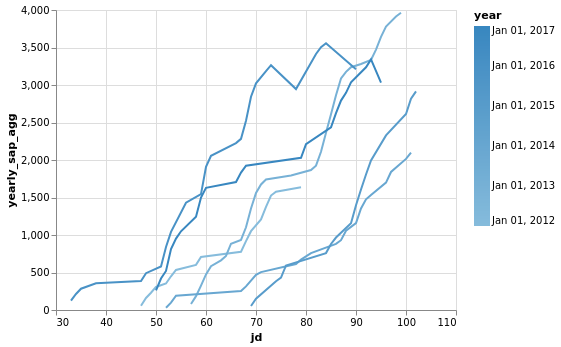

In [30]:
alt.Chart(
    stinson2019_df[
        (stinson2019_df["site_id"] == "HF")
    ]
).mark_line(color='black').encode(
    y="yearly_sap_agg:Q",
    x="jd",
    color = 'year'
).transform_aggregate(
    yearly_sap_agg='sum(yearly_sap)',
    groupby=['jd', 'year']
)

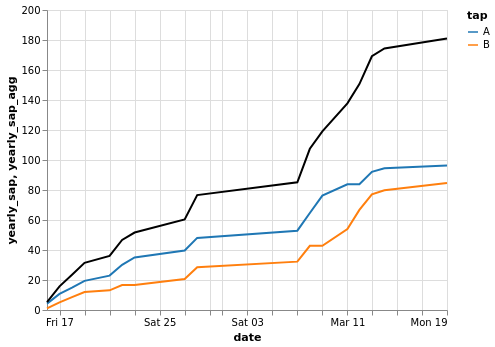

In [7]:
a+b

In [8]:
stinson2019_df[
    (stinson2019_df["tree"] == "HF1")
    & (stinson2019_df["year_int"] == 2012)
    & ((stinson2019_df["tap"] == "A") | (stinson2019_df["tap"] == "B"))].head()

,site,date,tree,species,tap,sugar,sap_wt,year,site_id,tree_id,tree_record_id,tap_record_id,jd,year_int,yearly_sap,yearly_sugar,tree_tap
0,Harvard Forest,2012-02-16,HF1,ACSA,A,2.7,4.24,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-16,HF.ACSA.HF1.A.2012-02-16,47,2012,4.24,11.448,HF1_A
1,Harvard Forest,2012-02-16,HF1,ACSA,B,2.4,1.08,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-16,HF.ACSA.HF1.B.2012-02-16,47,2012,1.08,2.592,HF1_B
24,Harvard Forest,2012-02-17,HF1,ACSA,B,2.3,3.96,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-17,HF.ACSA.HF1.B.2012-02-17,48,2012,5.04,11.700,HF1_B
23,Harvard Forest,2012-02-17,HF1,ACSA,A,2.6,6.47,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-17,HF.ACSA.HF1.A.2012-02-17,48,2012,10.71,28.270,HF1_A
47,Harvard Forest,2012-02-18,HF1,ACSA,B,2.4,3.54,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-18,HF.ACSA.HF1.B.2012-02-18,49,2012,8.58,20.196,HF1_B


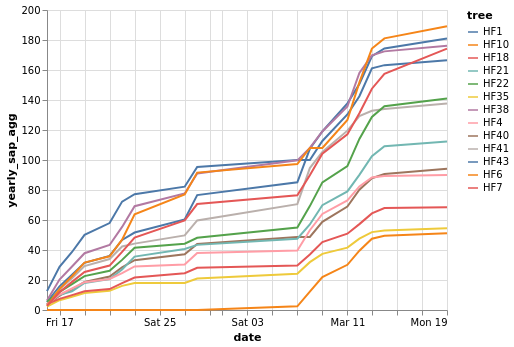

In [9]:
alt.Chart(
    stinson2019_df[(stinson2019_df["year_int"] == 2012)
    ]
).mark_line(color='black').encode(
    y="yearly_sap_agg:Q",
    x="date",
    color='tree'
).transform_aggregate(
    yearly_sap_agg='sum(yearly_sap)',
    groupby=['date','tree']
)

In [10]:
stinson2019_df[(stinson2019_df["tree"] == "HF1") & (stinson2019_df["year_int"] == 2012) & (stinson2019_df['tap']=='A')]

,site,date,tree,species,tap,sugar,sap_wt,year,site_id,tree_id,tree_record_id,tap_record_id,jd,year_int,yearly_sap,yearly_sugar,tree_tap
0,Harvard Forest,2012-02-16,HF1,ACSA,A,2.7,4.24,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-16,HF.ACSA.HF1.A.2012-02-16,47,2012,4.24,11.448,HF1_A
23,Harvard Forest,2012-02-17,HF1,ACSA,A,2.6,6.47,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-17,HF.ACSA.HF1.A.2012-02-17,48,2012,10.71,28.270,HF1_A
46,Harvard Forest,2012-02-18,HF1,ACSA,A,2.6,4.22,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-18,HF.ACSA.HF1.A.2012-02-18,49,2012,14.93,39.242,HF1_A
69,Harvard Forest,2012-02-19,HF1,ACSA,A,2.6,4.50,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-19,HF.ACSA.HF1.A.2012-02-19,50,2012,19.43,50.942,HF1_A
92,Harvard Forest,2012-02-21,HF1,ACSA,A,2.3,3.50,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-21,HF.ACSA.HF1.A.2012-02-21,52,2012,22.93,58.992,HF1_A
115,Harvard Forest,2012-02-22,HF1,ACSA,A,2.6,7.18,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-22,HF.ACSA.HF1.A.2012-02-22,53,2012,30.11,77.660,HF1_A
138,Harvard Forest,2012-02-23,HF1,ACSA,A,2.5,4.94,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-23,HF.ACSA.HF1.A.2012-02-23,54,2012,35.05,90.010,HF1_A
161,Harvard Forest,2012-02-27,HF1,ACSA,A,2.6,4.62,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-27,HF.ACSA.HF1.A.2012-02-27,58,2012,39.67,102.022,HF1_A
184,Harvard Forest,2012-02-28,HF1,ACSA,A,2.5,8.40,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-02-28,HF.ACSA.HF1.A.2012-02-28,59,2012,48.07,123.022,HF1_A
207,Harvard Forest,2012-03-07,HF1,ACSA,A,2.2,4.82,2012-01-01,HF,HF.ACSA.HF1,HF.ACSA.HF1.2012-03-07,HF.ACSA.HF1.A.2012-03-07,67,2012,52.89,133.626,HF1_A


In [11]:
HF_weather = pd.read_csv('data/HF_weather/raw/hf001-08-hourly-m.csv', parse_dates=['datetime'])

/home/steffen/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,5,7,9,11,13,15,17,19,21,23,25,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
c = alt.Chart(HF_weather[(HF_weather['datetime'].dt.year==2012) & ((HF_weather['jd'] < 81) & (HF_weather['jd'] > 47))]).mark_line().encode(x='datetime',y='airt')

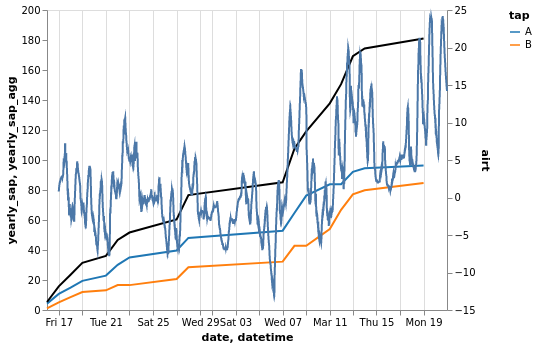

In [13]:
alt.layer((a+b), c).resolve_scale(
    y = 'independent'
)

In [18]:
stinson2019_df.groupby(['year','site_id'],dropna=True)['sap_wt'].sum()

year        site_id
2012-01-01  HF         1636.280000
2013-01-01  HF         3963.870000
2014-01-01  DOF         487.650000
            HF         2099.130000
            QC          314.660000
            SMM         992.270000
2015-01-01  DOF         353.640000
            HF         2915.690000
            QC          257.810000
            SMM         999.520000
2016-01-01  DOF         942.045000
            DR          359.543935
            HF         3577.670000
            INDU        267.870000
            QC          645.334000
            SMM        2192.870000
2017-01-01  DOF         459.990000
            DR          217.360000
            HF         3378.090000
            INDU        379.900000
            QC          450.260000
            SMM         559.900000
Name: sap_wt, dtype: float64

In [ ]:
stinson_2019_byforest = 